# Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

# Datasets

## MNIST

In [ ]:
def get_mnist():
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

  # Scale images to the [0, 1] range
  x_train = np.reshape(x_train, [-1, 784])
  x_train = x_train.astype("float32") / 255
  x_test = np.reshape(x_test, [-1, 784])

  x_test = x_test.astype("float32") / 255
  print("x_train shape:", x_train.shape)
  print(f"x_test shape: {x_test.shape}")
  
  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)
  print(f"y_train shape: {y_train.shape}")
  print(f"y_test shape:  {y_test.shape}")

  return (x_train, y_train), (x_test, y_test)
  


11490434/11490434 [==============================] - 0s 0us/step


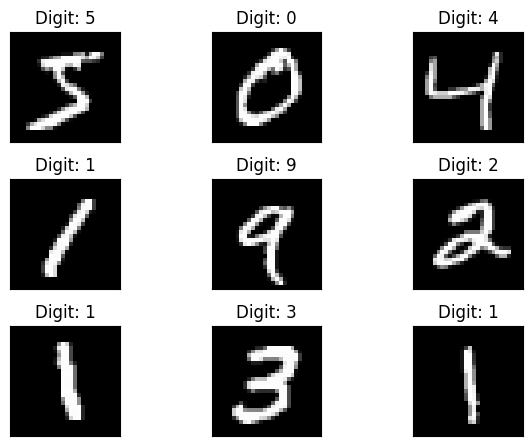

In [ ]:
 (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#data visualization
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(x_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
     

x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000, 10)
y_test shape:  (10000, 10)


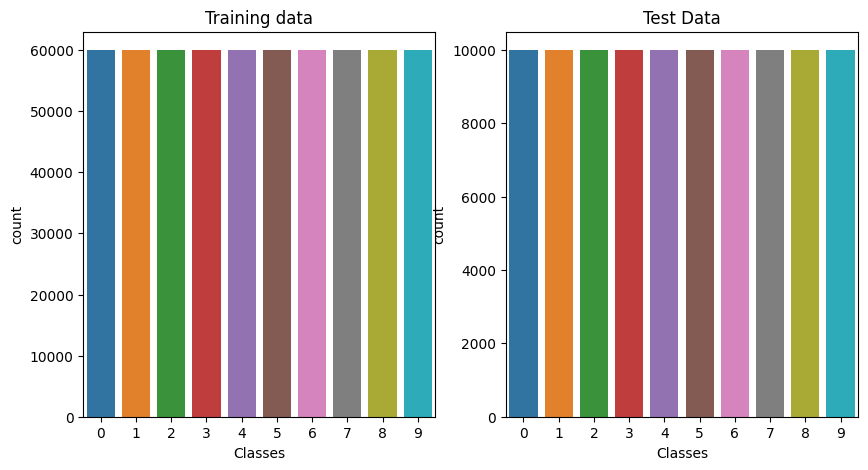

In [ ]:
(x_train, y_train), (x_test, y_test) = get_mnist()
ig, axs = plt.subplots(1,2, figsize=(10,5))

sns.countplot(y_train, ax=axs[0])
axs[0].set_title('Training data')
axs[0].set_xlabel('Classes')

sns.countplot(y_test, ax=axs[1])
axs[1].set_title('Test Data')
axs[1].set_xlabel('Classes')
plt.show()

## CIFAR-10

In [ ]:
def normalize(data):

  mean = np.mean(data, axis=0)
  data = data - mean
  std = np.std(data, axis = 0)
  data = data/std

  return data


def get_cifar10():

  (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

  x_train = normalize(x_train)
  x_test = normalize(x_test)

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, 10)
  y_test = keras.utils.to_categorical(y_test, 10)

  print("x_train shape:", x_train.shape)
  print(f"x_test shape: {x_test.shape}")
  print(f"y_train shape: {y_train.shape}")
  print(f"y_test shape: {y_test.shape}")

  return (x_train, y_train), (x_test, y_test)


# Keras MLP model

In [ ]:
(x_train, y_train), (x_test, y_test) = get_mnist()

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 784)
x_test shape: (10000, 784)
y_train shape: (60000, 10)
y_test shape:  (10000, 10)


In [ ]:
#x_train=x_train[:1000]
#y_train=y_train[:1000]

#x_test=x_test[:10000]
#y_test=y_test[:10000]

In [ ]:
len(y_train)

60000

## Model Class Definition

In [ ]:
class Keras_MLP:
  def __init__(self, input_size, output_size, lr=0.01, momentum=0.9, rms=0.999, hidden_layers=[256,256], dr= [0.45,0.45], activation="relu",mnorm=0):
    """
    if want to nullify a dropout/not add a dropout, set it to 1
    """
    self.mlp = keras.Sequential()
    # setting up all the layers with the proper dropouts and shapes
    for i in range(len(hidden_layers)):

      # first layer needs special treatment with the input dimensions
      if i == 0:
        if mnorm == 0:
          self.mlp.add(layers.Dense(hidden_layers[i], input_dim=input_size))
          self.mlp.add(layers.Activation(activation))
        else:
          self.mlp.add(layers.Dense(hidden_layers[i], kernel_constraint=max_norm(mnorm), input_dim=784))
          self.mlp.add(layers.Activation(activation))

      else:
        if mnorm == 0:
          self.mlp.add(layers.Dense(hidden_layers[i]))
          self.mlp.add(layers.Activation(activation))
        else:
          self.mlp.add(layers.Dense(hidden_layers[i], kernel_constraint=max_norm(mnorm)))
          self.mlp.add(layers.Activation(activation))
      if i < len(dr) and dr[i] >= 0 and dr[i] < 1:
        self.mlp.add(layers.Dropout(dr[i]))

    # setting up the last layer
    if mnorm == 0:
      self.mlp.add(layers.Dense(output_size))
      self.mlp.add(layers.Activation("softmax"))
    else:
      self.mlp.add(layers.Dense(output_size, kernel_constraint=max_norm(mnorm)))
      self.mlp.add(layers.Activation("softmax"))
    self.mlp.summary()

    # setting up adam to be hp searchable
    adam = keras.optimizers.Adam(
        learning_rate=lr,
        beta_1=momentum,
        beta_2=rms
    )

    self.mlp.compile(
        loss="categorical_crossentropy",
        optimizer=adam,
        metrics=["accuracy"]
    )
  
  def fit(self, x_train, y_train, batch_size, epochs=20, validation_split=0.1):
    print(x_train.shape)
    print(y_train.shape)
    return self.mlp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
  
  def predict(self, x_test):
    return self.mlp.predict(x_test)

  def evaluate(self, x_test, y_test):
    return self.mlp.evaluate(x_test, y_test)


## Testing

In [ ]:
input_size = x_train.shape[1]
output_size = y_train.shape[1]

In [ ]:

model = Keras_MLP(input_size, output_size, dr=[0.2,0.2])

avg=0

model.fit(x_train, y_train, 128, epochs=10, validation_split=0.1)

score = model.evaluate(x_test, y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)               

##Graph

In [ ]:
from matplotlib.figure import figaspect
max_norms = [0,0.1,1,2,3,4,5]
axes = []
for mn in max_norms:
  model = Keras_MLP(input_size, output_size, mnorm=mn)
  model.fit(x_train, y_train, 128, epochs=10, validation_split=0.1)

  score = model.evaluate(x_test, y_test)
  axes.append(score[1])


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 256)               200960    
                                                                 
 activation_81 (Activation)  (None, 256)               0         
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_82 (Dense)            (None, 256)               65792     
                                                                 
 activation_82 (Activation)  (None, 256)               0         
                                                                 
 dropout_29 (Dropout)        (None, 256)               0         
                                                                 
 dense_83 (Dense)            (None, 10)              

Text(0, 0.5, 'Test Accuracy')

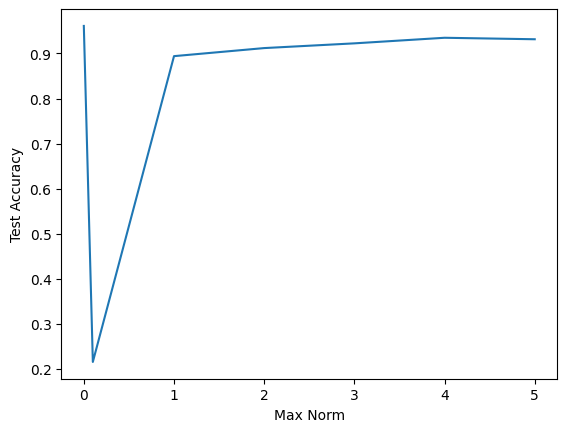

In [ ]:
fig = plt.figure(facecolor='w')
plt.plot(max_norms, axes)
plt.xlabel("Max Norm")
plt.ylabel("Test Accuracy")

In [ ]:
layers_size = [[1024,1024,1024],[2048,2048,2048],[4096,4096],[8192,8192]]
dropout = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5,0.5], [0.5,0.5]]
nodr = [[1,1,1],[1,1,1],[1,1],[1,1]]
axes = []
nodr_axes = []
for i in range(len(layers_size)):
  model = Keras_MLP(input_size, output_size, hidden_layers=layers_size[i], mnorm = 0, momentum = 0.95, dr = dropout[i])
  nodropout = Keras_MLP(input_size, output_size, hidden_layers=layers_size[i], mnorm = 0, momentum = 0.95, dr = nodr[i])
  model.fit(x_train, y_train, 128, epochs=20, validation_split=0.1)
  nodropout.fit(x_train, y_train, 128, epochs=20, validation_split=0.1)

  score = model.evaluate(x_test, y_test)
  axes.append(score[1])

  nodr_axes.append(nodropout.evaluate(x_test, y_test)[1])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 activation_1 (Activation)   (None, 1024)              0         
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1

<function matplotlib.pyplot.show(close=None, block=None)>

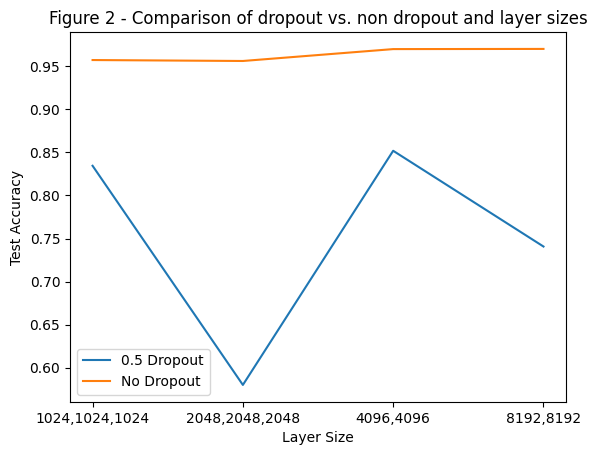

In [ ]:
fig = plt.figure(facecolor='w')
plt.plot(["1024,1024,1024","2048,2048,2048", "4096,4096", "8192,8192"], axes, label = "0.5 Dropout")
plt.plot(["1024,1024,1024","2048,2048,2048", "4096,4096", "8192,8192"], nodr_axes, label = "No Dropout")
plt.xlabel("Layer Size")
plt.ylabel("Test Accuracy")
plt.legend()
plt.title("Figure 2 - Comparison of dropout vs. non dropout and layer sizes")
plt.show

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 8192)              6430720   
                                                                 
 activation_78 (Activation)  (None, 8192)              0         
                                                                 
 dense_79 (Dense)            (None, 8192)              67117056  
                                                                 
 activation_79 (Activation)  (None, 8192)              0         
                                                                 
 dense_80 (Dense)            (None, 10)                81930     
                                                                 
 activation_80 (Activation)  (None, 10)                0         
                                                                 
Total params: 73,629,706
Trainable params: 73,629,706

## RUN THIS ONE ETHAN AND TRY AND PRINT OUT THE VALIDATION ACCURACIES OVER THE EPOCHS

In [ ]:
nodropout = Keras_MLP(input_size, output_size, hidden_layers=[8192,8192], mnorm = 4, momentum = 0.95, dr = [1,1])
ndr_rank = nodropout.fit(x_train, y_train, 128, epochs=50, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8192)              6430720   
                                                                 
 activation (Activation)     (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              67117056  
                                                                 
 activation_1 (Activation)   (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                81930     
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 73,629,706
Trainable params: 73,629,706
No

In [ ]:
ndr_score = nodropout.evaluate(x_test, y_test)

dropout = Keras_MLP(input_size, output_size, hidden_layers=[8192,8192], mnorm = 4, momentum = 0.95, dr = [0.1,0.1])
dr_rank = dropout.fit(x_train, y_train, 128, epochs=50, validation_split=0.1)

dr_score = dropout.evaluate(x_test, y_test)

print("dropout test", dr_score[1])
print("no dropout test", ndr_score[1])

313/313 [==============================] - 1s 4ms/step - loss: 0.1574 - accuracy: 0.9519
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              6430720   
                                                                 
 activation_3 (Activation)   (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 8192)              67117056  
                                                                 
 activation_4 (Activation)   (None, 8192)              0         
                                                                 
 dropout_1 (Dropout)         (None, 8192)              0         
                               

## validation over epochs of 0.5 dropout vs no dropout

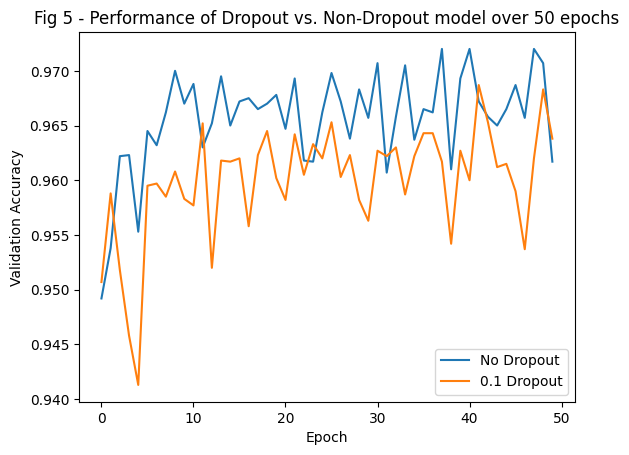

In [ ]:
fig = plt.figure(facecolor='w')
plt.plot(list(range(0,50)), [0.9492,0.9538,0.9622,0.9623,0.9553,0.9645,0.9632,0.9662,0.9700,0.9670,0.9688,0.9630,0.9652,0.9695,0.9650,0.9672,0.9675,0.9665,0.9670,0.9678,0.9647,0.9693,0.9618,0.9617,0.9662,0.9698,0.9672,0.9638,0.9683,0.9657,0.9707,0.9607,0.9658,0.9705,0.9637,0.9665,0.9662,0.9720,0.9610,0.9693,0.9720,0.9672,0.9658,0.9650,0.9665,0.9687,0.9657,0.9720,0.9707,0.9617], label="No Dropout")
plt.plot(list(range(0,50)), [0.9507, 0.9588, 0.9518,0.9458,0.9413,0.9595,0.9597,0.9585,0.9608,0.9583,0.9577,0.9652,0.9520,0.9618,0.9617,0.9620,0.9558,0.9623,0.9645,0.9602,0.9582,0.9642,0.9605,0.9633,0.9620,0.9653,0.9603,0.9623,0.9582,0.9563,0.9627,0.9622,0.9630,0.9587,0.9622,0.9643,0.9643,0.9617,0.9542,0.9627,0.9600,0.9687,0.9653,0.9612,0.9615,0.9590,0.9537,0.9620,0.9683,0.9638], label="0.1 Dropout")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Fig 5 - Performance of Dropout vs. Non-Dropout model over 50 epochs")
plt.legend()

Dropout hp search

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 2048)              1607680   
                                                                 
 activation_71 (Activation)  (None, 2048)              0         
                                                                 
 dropout_53 (Dropout)        (None, 2048)              0         
                                                                 
 dense_72 (Dense)            (None, 2048)              4196352   
                                                                 
 activation_72 (Activation)  (None, 2048)              0         
                                                                 
 dropout_54 (Dropout)        (None, 2048)              0         
                                                                 
 dense_73 (Dense)            (None, 2048)            

Text(0, 0.5, 'Test Accuracy')

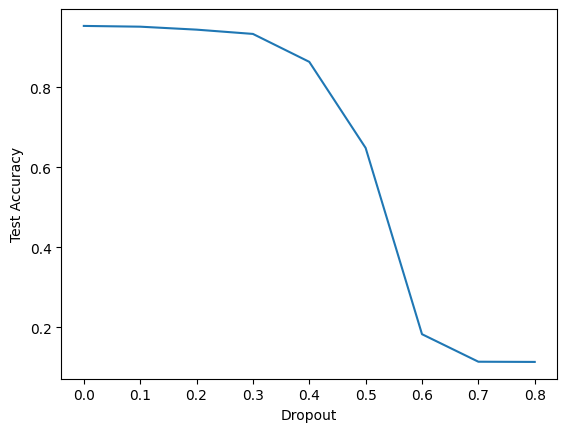

In [ ]:

dropouts = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
axes = []
for dr in dropouts:
  model = Keras_MLP(input_size, output_size, dr=[dr,dr,dr], hidden_layers=[2048,2048,2048])
  model.fit(x_train, y_train, 128, epochs=20, validation_split=0.1)

  score = model.evaluate(x_test, y_test)
  axes.append(score[1])

fig = plt.figure(facecolor='w')
plt.plot(dropouts, axes)
plt.xlabel("Dropout")
plt.ylabel("Test Accuracy")

Large figures

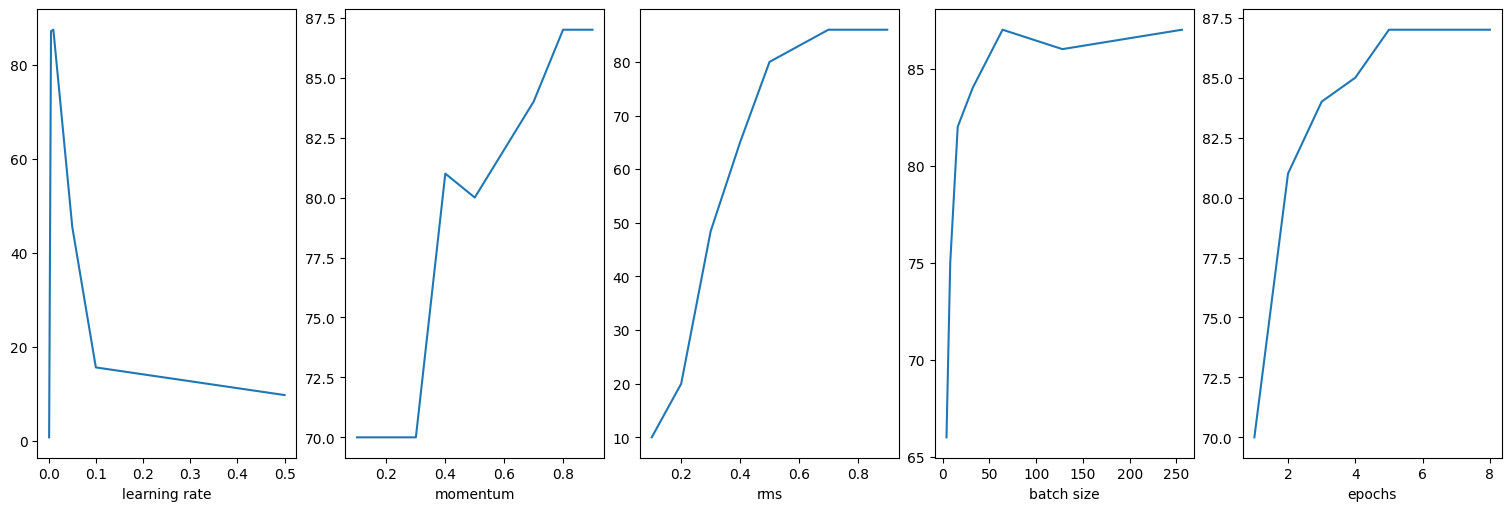

<Figure size 100x500 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=1, constrained_layout=True, figsize=(15,5))
fig = plt.figure(figsize=(1,5),facecolor='w')
fig.suptitle('Fig 4 - Hyper Paramater Search')

axes[0].plot([0.5,0.1,0.05,0.01,0.005,0.001], [9.8,15.68,45.6,87.5,87.2,0.81])
axes[0].set_xlabel("learning rate")

axes[1].plot([0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.9], [70,70,81,80,82,84,87,87])
axes[1].set_xlabel("momentum")

axes[2].plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], [10,20,48.4,65,80,83,86,86,86])
axes[2].set_xlabel("rms")

axes[3].plot([4,8,16,32,64,128,256], [66,75,82,84,87,86,87])
axes[3].set_xlabel("batch size")

axes[4].plot([1,2,3,4,5,6,7,8], [70,81,84,85,87,87,87,87])
axes[4].set_xlabel("epochs")


fig.show()